# Training on HeLa dataset 
Google Colab Notebook \
Author: Matthew Robichaud

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')

# Location of Zip File
drive_path = '/content/gdrive/MyDrive/UW/ML-Data/HeLaTrainW.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
if not os.path.exists(local_path + '/HeLaTrain'):
    !cp '{drive_path}' .
    # Navigate to the copied file and unzip it quietly
    !unzip -q '/content/HeLaTrainW.zip'

sys.path.insert(0,'/content/gdrive/MyDrive/UW/ML-Data/harmonic')
sys.path.insert(0,'/content/gdrive/MyDrive/UW/ML-Data/')

from harmonic import * 
import loader

Mounted at /content/gdrive


In [ ]:
from embeddings import Embedding as Emb1
from sq_embeddings import Embedding as Emb2
from sinconv import AddHSine,AddSine
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.utils.data as data 

Hela = loader.hela('HeLaTrain/')

# Training

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sins = [[-7.375255107879639, 5.203563690185547, 45.27313232421875],
 [-7.378573417663574, -1.9893327951431274, 20.848262786865234],
 [-7.0850653648376465, -2.456326961517334, 41.53719711303711],
 [11.45650577545166, -2.489238739013672, 31.25278091430664],
 [-1.703177571296692, -6.168859958648682, 5.964511394500732],
 [11.166621208190918, 5.2173919677734375, 38.755393981933594],
 [-0.6013728380203247, 12.734735488891602, 3.7188491821289062],
 [6.044683933258057, 12.558919906616211, 52.94304656982422],
 [5.92817497253418, -0.7977170944213867, 54.80228805541992],
 [-0.38155657052993774, 23.551265716552734, 35.34095001220703],
 [1.972337245941162, 5.383609294891357, 46.41643524169922],
 [4.012279033660889, -4.179959774017334, 35.26789093017578]]

npsins = np.array(sins)
guides = loader.guide_function(npsins[:,0],npsins[:,1],npsins[:,2],448,448)


NameError: name 'loader' is not defined

In [ ]:
guides.shape

torch.Size([12, 448, 448])

### Load Model

In [ ]:
from harmonic.embeddings import *
#from harmonic.sq_unet import UNet
from harmonic.unet import aUNet as UNet
from torch.utils.data import DataLoader
errors = []

train_data = loader.Reader(Hela.rgb, Hela.labels, Hela.edges, 
                           Hela.transform, Hela.transform_target, 
                           loader=loader.gray_loader)
generator = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)

unet = UNet(1, sins).to(device)
optim = torch.optim.Adam(unet.parameters(),lr=1e-5,weight_decay=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

In [ ]:
pytorch_total_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
pytorch_total_params

30332848

##Pretrained backbone

In [ ]:
from harmonic.embeddings import *
from harmonic.unet import bUNet
from torch.utils.data import DataLoader

train_data = loader.Reader(Hela.rgb, Hela.labels, Hela.edges, Hela.transform, Hela.transform_target)
generator = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)

unet = bUNet(3, sins).to(device)
optim = torch.optim.Adam(unet.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

## Optional PreTraining

### Hela (CV init) 

In [ ]:
from os.path import join

# HELA PRETRAIN FROM CVINIT
modelpath = '/content/gdrive/MyDrive/UW/ML-Data/'
caption = join(modelpath,"hela")
if os.path.exists(caption + '_cvinit_ckp.t7'):
    data = torch.load(caption + '_cvinit_ckp.t7')
    #unet.load_state_dict(data['model_state_dict'])
    #optim.load_state_dict(data['optimizer_state_dict'])
    #epoch = data['epoch']
else:
    print('no PT')

trained_dict = data['model_state_dict']
# Using items() + list comprehension
# Substring Key match in dictionary
res = dict(filter(lambda item: 'module.up' not in item[0], trained_dict.items()))
res = dict(filter(lambda item: 'module.out' not in item[0], res.items()))

res2 = {}
for key in res.keys():
    new_key = key[7:]
    res2[new_key] = res[key]

unet.load_state_dict(res2,strict=False)



_IncompatibleKeys(missing_keys=['up1.sinconv.addcoords.0.alpha', 'up1.sinconv.addcoords.0.beta', 'up1.sinconv.addcoords.0.phase', 'up1.sinconv.addcoords.1.alpha', 'up1.sinconv.addcoords.1.beta', 'up1.sinconv.addcoords.1.phase', 'up1.sinconv.addcoords.2.alpha', 'up1.sinconv.addcoords.2.beta', 'up1.sinconv.addcoords.2.phase', 'up1.sinconv.addcoords.3.alpha', 'up1.sinconv.addcoords.3.beta', 'up1.sinconv.addcoords.3.phase', 'up1.sinconv.addcoords.4.alpha', 'up1.sinconv.addcoords.4.beta', 'up1.sinconv.addcoords.4.phase', 'up1.sinconv.addcoords.5.alpha', 'up1.sinconv.addcoords.5.beta', 'up1.sinconv.addcoords.5.phase', 'up1.sinconv.addcoords.6.alpha', 'up1.sinconv.addcoords.6.beta', 'up1.sinconv.addcoords.6.phase', 'up1.sinconv.addcoords.7.alpha', 'up1.sinconv.addcoords.7.beta', 'up1.sinconv.addcoords.7.phase', 'up1.sinconv.addcoords.8.alpha', 'up1.sinconv.addcoords.8.beta', 'up1.sinconv.addcoords.8.phase', 'up1.sinconv.addcoords.9.alpha', 'up1.sinconv.addcoords.9.beta', 'up1.sinconv.addcoord

## Training routine

In [ ]:
from os.path import join

modelpath = '/content/gdrive/MyDrive/UW/ML-Data/'
caption = join(modelpath,"hela")
if os.path.exists(caption + '_base0_ckp0.t7'):
    data = torch.load(caption + '_base0_ckp0.t7')
    unet.load_state_dict(data['model_state_dict'])
    optim.load_state_dict(data['optimizer_state_dict'])
    epoch = data['epoch']
    errors = data['error']
else:
    print('no PT')
    epoch = 0

#epoch=0

#unet.backbone.requires_grad_(True)
for e in range(epoch,4000):
    epoch = e
    for x,y,z in generator:
        optim.zero_grad()
        y_grad, weight =embedder(y.squeeze(1).to(device))
        y_pred =unet(x.to(device))
        z = z.to(device).float()
        loss = torch.nn.functional.l1_loss(y_pred,y_grad, reduce=False)
        edge_loss = torch.mean(torch.mean(loss, dim=1)*z)
        loss = torch.mean((weight.detach() * torch.mean(loss, dim=1)))+10.*edge_loss
        loss.backward()
        errors+=[loss.item()]
        optim.step()
      
    print(np.log(loss.item()))
    if (e%100 == 0):
        torch.save({
                'epoch': e,
                'model_state_dict': unet.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'loss': loss,
                'error': errors
            }, caption + '_base0_ckp0.t7')

plt.plot(errors)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


-2.590671923150771
-2.595759749885819
-2.6131254992180706
-2.662072960559921
-2.60703422216141
-2.607829268560191
-2.570318672458855
-2.5528615301310076
-2.5971822703775707
-2.6296281977771847
-2.6890820038253063
-2.565941342779838
-2.5691046066461514
-2.616953694674709
-2.604602781885175
-2.5834692279264
-2.5929359053210304
-2.5881086891820737
-2.6350769956737676
-2.6277138942506446
-2.584295420711429
-2.5496757005777653
-2.634336611122925
-2.6751079096854276
-2.6231469456579357
-2.7230443499333568
-2.6017382148062
-2.5107643831688633
-2.6318079248896837
-2.5597407371087018
-2.6827588225391965
-2.723362392617638
-2.442674460027656
-2.6680714790017044
-2.6942537052317017
-2.622469197655923
-2.666561262328826
-2.6136903594383223
-2.6010875710432417
-2.5029719384450964
-2.6431655430615577
-2.5355594433278954
-2.5384309357205272
-2.5052398681668215
-2.581735949260201
-2.6691987332398415
-2.5819636021524865
-2.638744930868916
-2.51453180284302
-2.561207072483924
-2.5887350698217406
-2.5064

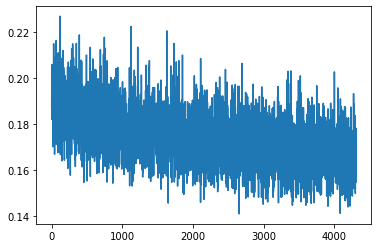

In [ ]:
plt.plot(errors)